In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
#READ DATA

filename = 'data/FeSO4.txt'

with open(filename, 'r') as f:
    lines = f.readlines()

# Determine dimensions from file structure
n_rows = len(lines)
n_cols = len(lines[0].strip().split())

# Read as 2D numpy array
data_2d = np.loadtxt(filename).reshape(n_rows, n_cols)

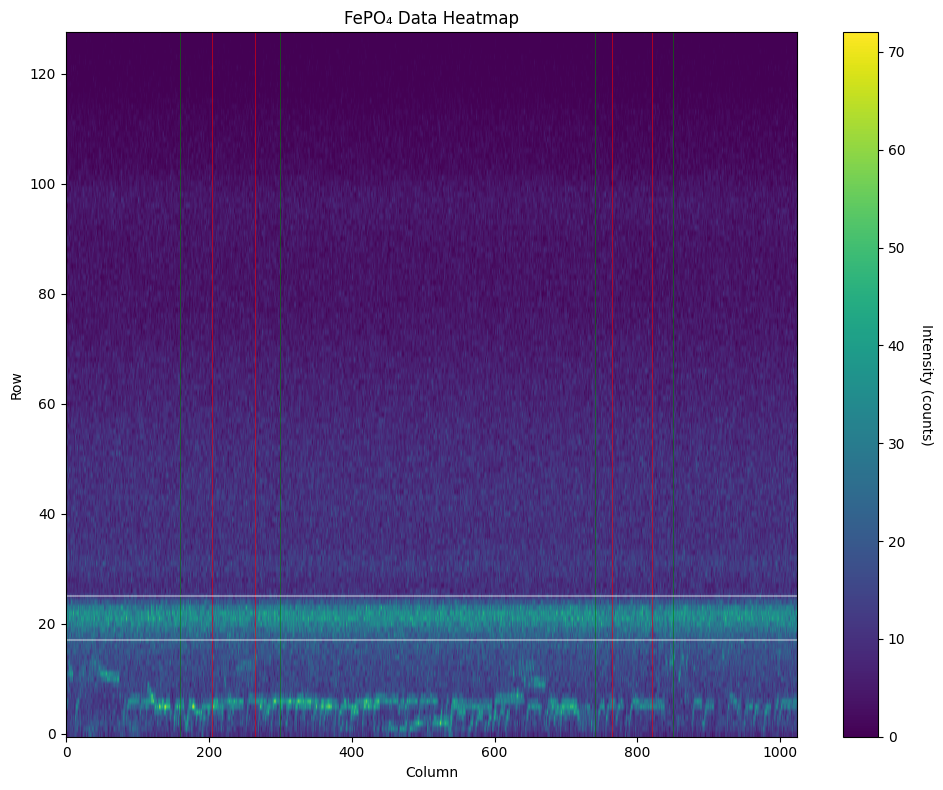

In [33]:
row_low, row_high = 17, 25   # rows you want to use

# Fit 1:
fit1_low=160
fit1_high=300

peak1_low=205
peak1_high=265

# Fit 2:
fit2_low=740
fit2_high=850

peak2_low=765
peak2_high=820



# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data_2d, cmap='viridis', aspect='auto', origin='lower')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity (counts)', rotation=270, labelpad=20)

# Labels
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('FePO₄ Data Heatmap')

plt.tight_layout()

#peak
plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

#fit
plt.axvline(fit1_low, color = 'green', linewidth = 0.4)
plt.axvline(fit1_high, color = 'green', linewidth = 0.4)
plt.axvline(fit2_low, color = 'green', linewidth = 0.4)
plt.axvline(fit2_high, color = 'green', linewidth = 0.4)

plt.axhline(row_low,color= "white",alpha=0.4)
plt.axhline(row_high,color= "white",alpha=0.4)
plt.show()


In [34]:
# Restrict to useful band in Y
band = data_2d[row_low:row_high+1, :]  # shape: (rows, cols)

# Sum (or average) over rows to make a 1D spectrum vs column
spectrum = band.sum(axis=0)   # or band.mean(axis=0)

channels = np.arange(band.shape[1])    # x-axis = channel index

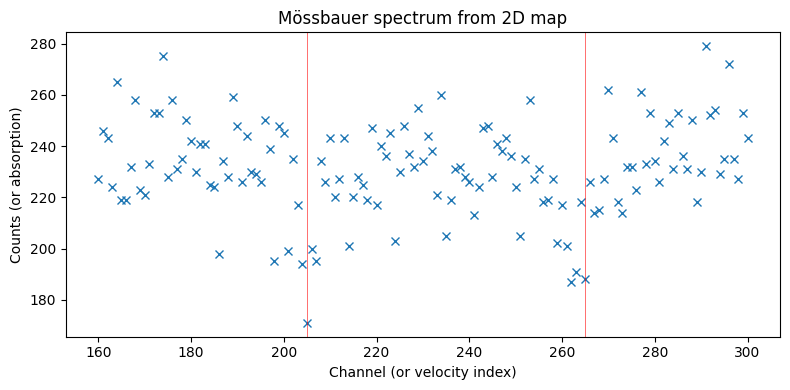

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit1_low:fit1_high+1], spectrum[fit1_low:fit1_high+1],'x')
plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.show()

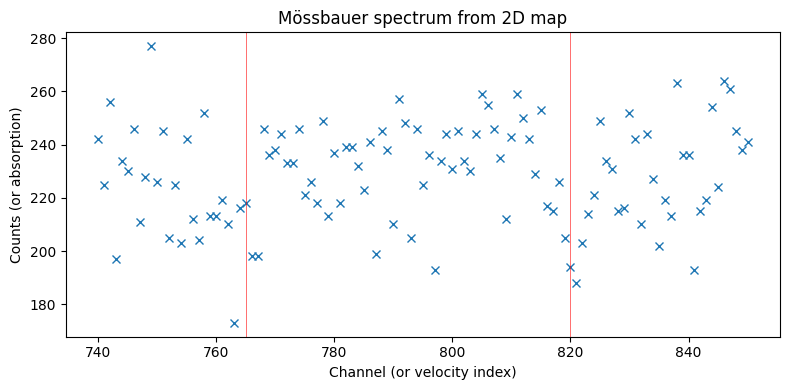

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit2_low:fit2_high+1], spectrum[fit2_low:fit2_high+1],'x')
plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

plt.show()

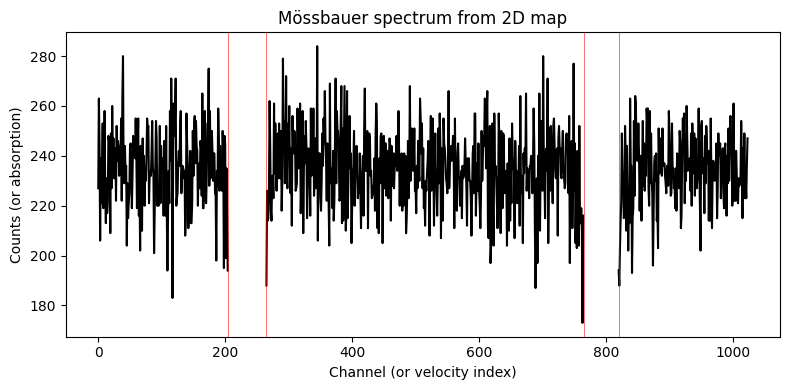

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(channels[0:peak1_low], spectrum[0:peak1_low],'-k')
plt.plot(channels[peak1_high:peak2_low], spectrum[peak1_high:peak2_low],'-k')
plt.plot(channels[peak2_high:], spectrum[peak2_high:],'-k')


plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()

plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak1_high, color = 'red', linewidth = 0.4)
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_high, color = 'red', linewidth = 0.4)

plt.show()

Background mean: 234.5523704520397
Background sigma: 15.540173048275237


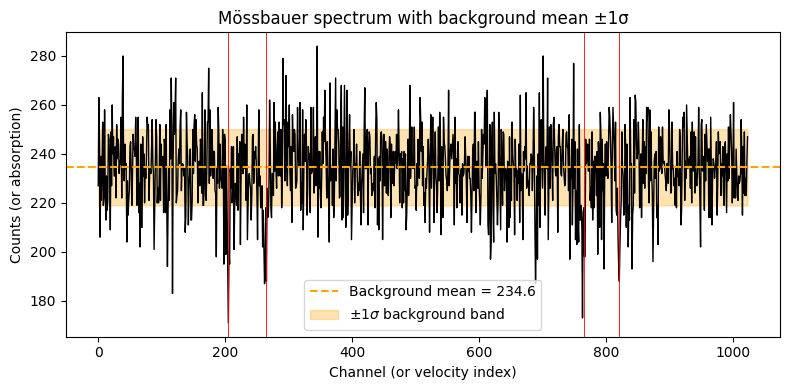

In [38]:
# Boolean mask for background channels (outside both peak regions)
bg_mask = (
    (channels < peak1_low) |
    ((channels > peak1_high) & (channels < peak2_low)) |
    (channels > peak2_high)
)

# Extract background y-values
bg_values = spectrum[bg_mask]

bg_mean = bg_values.mean()
bg_sigma = bg_values.std(ddof=1)   # sample sigma [web:35]

print("Background mean:", bg_mean)
print("Background sigma:", bg_sigma)

# Plot spectrum with background band
plt.figure(figsize=(8, 4))

# Your three background segments + peaks (optional: show full spectrum)
plt.plot(channels, spectrum, '-k', lw=1)

# Horizontal mean line
plt.axhline(bg_mean, color='orange', linestyle='--', label=f'Background mean = {bg_mean:.1f}')

# Shaded ±1σ band over the *background* x-range
x_bg = channels[bg_mask]
plt.fill_between(
    x_bg,
    bg_mean - bg_sigma,
    bg_mean + bg_sigma,
    color='orange',
    alpha=0.3,
    label=r'$\pm 1\sigma$ background band'
)  # [web:23][web:28]

# Peak markers
plt.axvline(peak1_low,  color='red', linewidth=0.6)
plt.axvline(peak1_high, color='red', linewidth=0.6)
plt.axvline(peak2_low,  color='red', linewidth=0.6)
plt.axvline(peak2_high, color='red', linewidth=0.6)

plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum with background mean ±1σ')
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
from scipy.optimize import curve_fit


def double_gauss_bg(x, A1, x01, sigma1, A2, x02, sigma2, m, c):
    """
    Two Gaussians on a linear background.
    A1, A2: amplitudes (negative for absorption)
    x01, x02: centers
    sigma1, sigma2: widths (sigma)
    m, c: background slope and intercept
    """
    g1 = A1 * np.exp(-(x - x01)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - x02)**2 / (2 * sigma2**2))
    bg = m * x + c
    return g1 + g2 + bg

In [47]:
# Fit regions
# fit1_low, fit1_high = 150, 350
# fit2_low, fit2_high = 715, 850

# Extract x,y for each window
x1 = channels[fit1_low:fit1_high+1]
y1 = spectrum[fit1_low:fit1_high+1]

x2 = channels[fit2_low:fit2_high+1]
y2 = spectrum[fit2_low:fit2_high+1]


In [53]:
# Peak windows for guidance
# peak1_low, peak1_high = 225, 275
# peak2_low, peak2_high = 750, 800

# Rough centers
x01_guess = (peak1_low + peak1_high) / 2 - 20   # left line of doublet
x02_guess = (peak1_low + peak1_high) / 2 + 20   # right line of doublet

x03_guess = (peak2_low + peak2_high) / 2 - 30
x04_guess = (peak2_low + peak2_high) / 2 + 30

# Rough amplitudes: dips below background
A1_guess = - (bg_mean - y1.min()) * 0.6
A2_guess = - (bg_mean - y1.min()) * 0.6

A3_guess = - (bg_mean - y2.min()) * 0.8
A4_guess = - (bg_mean - y2.min()) * 0.8

sigma_guess1 = 8.0   # adjust if peaks are wider/narrower
sigma_guess2 = 8.0
sigma_guess3 = 4.0
sigma_guess4 = 4.0

# Background init from edges of each window (assume nearly flat)
# def linear_bg_guess(x, y):
#     c0 = (y[0] + y[-1]) / 2
#     m0 = (y[-1] - y[0]) / (x[-1] - x[0] + 1e-9)
#     return m0, c0

m1_guess, c1_guess = [0,bg_mean]
m2_guess, c2_guess = [0,bg_mean]

In [54]:
# Fit 1
p0_1 = [A1_guess, x01_guess, sigma_guess1,
        A2_guess, x02_guess, sigma_guess2,
        m1_guess, c1_guess]

print(p0_1)

popt1, pcov1 = curve_fit(double_gauss_bg, x1, y1, p0=p0_1)  # [web:46][web:49]

# Fit 2
p0_2 = [A3_guess, x03_guess, sigma_guess3,
        A4_guess, x04_guess, sigma_guess4,
        m2_guess, c2_guess]

popt2, pcov2 = curve_fit(double_gauss_bg, x2, y2, p0=p0_2)


[np.float64(-38.13142227122382), 215.0, 8.0, np.float64(-38.13142227122382), 255.0, 8.0, 0, np.float64(234.5523704520397)]


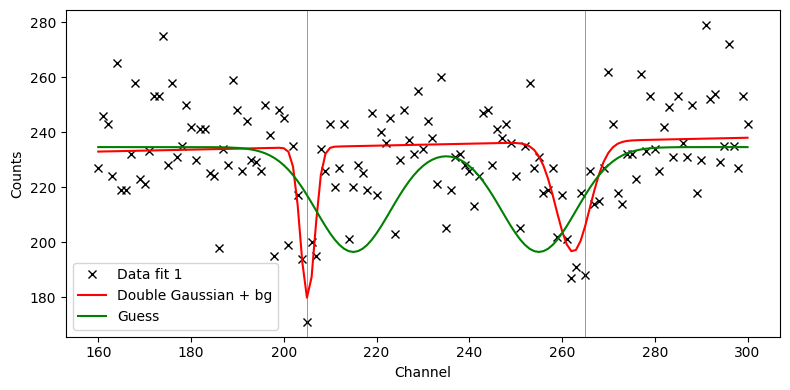

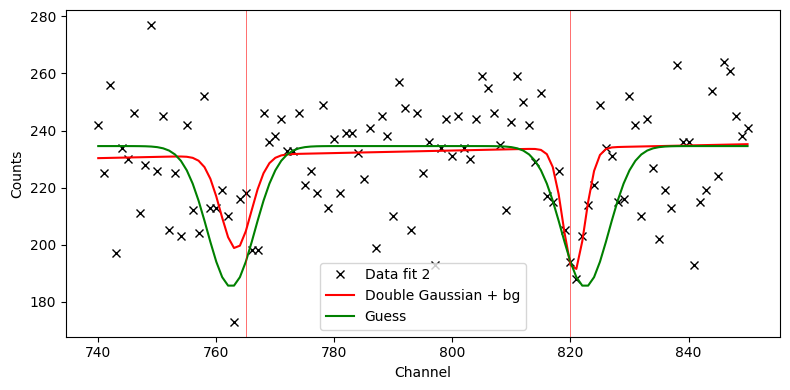

In [55]:
# Fit 1
y1_fit = double_gauss_bg(x1, *popt1)
y1_guess = double_gauss_bg(x1, *p0_1)
plt.figure(figsize=(8, 4))
plt.plot(x1, y1, 'kx', label='Data fit 1')
plt.plot(x1, y1_fit, 'r-', label='Double Gaussian + bg')
plt.plot(x1, y1_guess, 'g-', label='Guess')

plt.axvline(peak1_low, color='red', linewidth=0.4)
plt.axvline(peak1_high, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('peak1.pdf')
plt.savefig('peak1.png')

plt.show()

# Fit 2
y2_fit = double_gauss_bg(x2, *popt2)
y2_guess = double_gauss_bg(x2, *p0_2)

plt.figure(figsize=(8, 4))
plt.plot(x2, y2, 'kx', label='Data fit 2')
plt.plot(x2, y2_fit, 'r-', label='Double Gaussian + bg')
plt.plot(x2, y2_guess, 'g-', label='Guess')


plt.axvline(peak2_low, color='red', linewidth=0.4)
plt.axvline(peak2_high, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('peak2.pdf')
plt.savefig('peak2.png')
plt.show()
